In [1]:
from pyspark import SparkContext, SparkConf
cf = SparkConf()
cf.set("spark.submit.deployMode","client")
sc = SparkContext.getOrCreate(cf)
from pyspark.sql import SparkSession
spark = SparkSession \
	    .builder \
	    .appName("TransitTrends-Taxi-Data-Cleaning") \
	    .config("spark.some.config.option", "some-value") \
	    .getOrCreate()
        #.config("spark.driver.extraJavaOptions", "-Dsun.net.client.defaultConnectTimeout=100000 -Dsun.net.client.defaultReadTimeout=100000") \
        #.config("spark.executor.heartbeatInterval", "100000ms") \
        #.config("spark.network.timeout", "12000s") \


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/08 20:41:48 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/05/08 20:41:48 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/05/08 20:41:48 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/05/08 20:41:48 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


In [2]:
#importing libraries
from pyspark.sql.functions import lit
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
import math
import time
import pyspark.sql.functions as F
from pyspark.sql.functions import concat
from pyspark.sql.functions import count,asc
import matplotlib.pyplot as plt
from pyspark.sql.functions import desc
from pyspark.sql.functions import sum

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/miniconda3/share/proj failed


In [3]:
# importing green cabs data, dropping unnecessary coloumns and renaming few coloumns to match yellow cabs data:
#green_cabs_df = spark.read.csv(path='/shared/TAXI_SAMPLE/GREEN_CABS/',header=True, inferSchema= True).withColumn("taxi_type", lit("green")).drop("trip_type").withColumnRenamed("lpep_dropoff_datetime", "tpep_dropoff_datetime").withColumnRenamed("lpep_pickup_datetime", "tpep_pickup_datetime")
green_cabs_df = spark.read.option("dictionaryFilterEnabled", "false").parquet("/shared/TAXI/GREEN_CABS/").withColumn("taxi_type", lit("green")).drop("trip_type").withColumnRenamed("lpep_dropoff_datetime", "tpep_dropoff_datetime").withColumnRenamed("lpep_pickup_datetime", "tpep_pickup_datetime")

# importing yellow cabs data:
#yellow_cabs_df = spark.read.csv(path='/shared/TAXI_SAMPLE/YELLOW_CABS/',header=True, inferSchema= True).withColumn("taxi_type", lit("yellow"))
yellow_cabs_df = spark.read.option("dictionaryFilterEnabled", "false").parquet("/shared/TAXI/YELLOW_CABS/").withColumn("taxi_type", lit("yellow"))

# note: sometime there might be .ipynb checkpoints in /shared/GREEN_CABS folder. remove them hdfs before running this cell
yellow_cabs_df.printSchema()

23/05/08 20:42:16 WARN org.apache.spark.scheduler.cluster.YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/05/08 20:42:31 WARN org.apache.spark.scheduler.cluster.YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/05/08 20:42:46 WARN org.apache.spark.scheduler.cluster.YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/05/08 20:43:01 WARN org.apache.spark.scheduler.cluster.YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/05/08 20:43:16 WARN org.apache.spark.scheduler.cluster.YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are regist

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: integer (nullable = true)
 |-- taxi_type: string (nullable = false)



In [4]:
green_cabs_df.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- ehail_fee: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- taxi_type: string (nullable = false)



In [5]:
print(green_cabs_df.count())

9944318


In [6]:
print(yellow_cabs_df.count())

179807942


In [7]:
# combining yellow and green cabs data into a single dataset:
cabs_df = yellow_cabs_df.union(green_cabs_df)
# dropping unnnecessary coloumns:
cabs_df = cabs_df.drop("store_and_fwd_flag")

In [8]:
print(cabs_df.count())

189752260


In [9]:
# Clean the column names
cabs_df = cabs_df.select([F.col(column).alias(column.strip()) for column in cabs_df.columns])
#Filter for data in 2019-2022, removing the last week of 2018 and begining of 2023 from the dataset
cabs_df = cabs_df.filter(F.year("tpep_pickup_datetime").isin([2019, 2020, 2021, 2022]))

In [10]:
#converting pickup and dropoff datetime to timestamp
cabs_df = cabs_df.withColumn("pickup_date_time", F.to_timestamp(cabs_df["tpep_pickup_datetime"], "MM/dd/yyyyHH:mm:ss"))
cabs_df = cabs_df.withColumn("dropoff_date_time", F.to_timestamp(cabs_df["tpep_dropoff_datetime"], "MM/dd/yyyyHH:mm:ss"))

In [11]:
#dropping unnecesary colomns
cabs_df = cabs_df.drop("tpep_pickup_datetime","tpep_dropoff_datetime")
print(cabs_df.count())

189749973


In [12]:
#cabs_df = cabs_df.withColumn("pickup_datetime", cabs_df["tpep_pickup_datetime"].cast("timestamp"))
cabs_df = cabs_df.withColumn("month", F.month(cabs_df["pickup_date_time"])).withColumn("year", F.year(cabs_df["pickup_date_time"])).withColumn("pickup_date", F.to_date(cabs_df["pickup_date_time"]))

# Analysing monthly ride frequency

In [13]:
monthly_records = cabs_df.select("month","year","taxi_type")

In [14]:
monthly_records.show(5)

+-----+----+---------+
|month|year|taxi_type|
+-----+----+---------+
|    3|2019|   yellow|
|    3|2019|   yellow|
|    3|2019|   yellow|
|    3|2019|   yellow|
|    3|2019|   yellow|
+-----+----+---------+
only showing top 5 rows



In [57]:
count_df = monthly_records.groupBy('year','month','taxi_type').agg(count('*').alias('count')).orderBy(asc('year'), asc('month'), asc('taxi_type'))
count_df.show(5)

+----+-----+---------+-------+
|year|month|taxi_type|  count|
+----+-----+---------+-------+
|2019|    1|    green| 672017|
|2019|    1|   yellow|7696390|
|2019|    2|    green| 615582|
|2019|    2|   yellow|7049178|
|2019|    3|    green| 643020|
+----+-----+---------+-------+
only showing top 5 rows



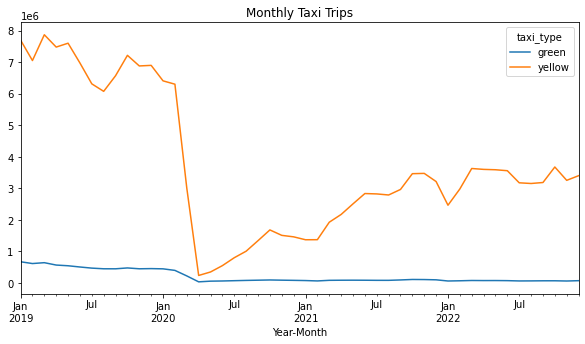

In [58]:
count_pd = count_df.toPandas()
count_pivot = count_pd.pivot(index=['year', 'month'], columns='taxi_type', values='count')
count_pivot.index = pd.to_datetime(count_pivot.index.map(lambda x: '-'.join(map(str, x))))
count_pivot.plot(figsize=(10,5))
plt.xlabel('Year-Month')
plt.title('Monthly Taxi Trips')
plt.savefig('TAXI/plots/trips_per_month.png' , dpi=500)
plt.show()
plt.close()

In [19]:

count_df = monthly_records.filter(monthly_records.taxi_type == 'yellow').groupBy('year','month','taxi_type').agg(count('*').alias('count')).orderBy(asc('year'), asc('month'), asc('taxi_type'))
count_df.show(5)

+----+-----+---------+-------+
|year|month|taxi_type|  count|
+----+-----+---------+-------+
|2019|    1|   yellow|7696390|
|2019|    2|   yellow|7049178|
|2019|    3|   yellow|7866400|
|2019|    4|   yellow|7475959|
|2019|    5|   yellow|7598543|
+----+-----+---------+-------+
only showing top 5 rows



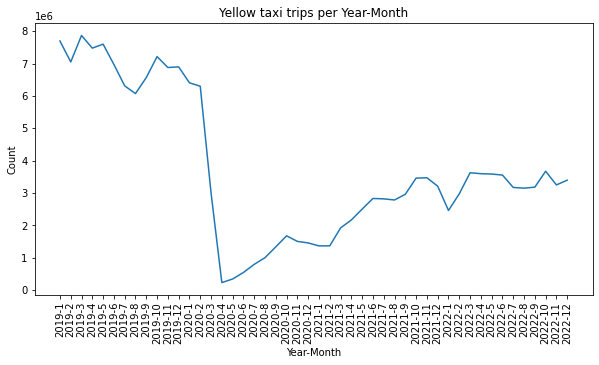

In [21]:
pd_df = count_df.toPandas()
plt.figure(figsize=(10, 5))
plt.plot(pd_df['year'].astype(str) + '-' + pd_df['month'].astype(str), pd_df['count'])
plt.title('Yellow taxi trips per Year-Month')
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.savefig('TAXI/plots/yellow_taxi_trips_per_month.png' , dpi=500)
plt.show()
plt.close()

In [22]:

count_df = monthly_records.filter(monthly_records.taxi_type == 'green').groupBy('year','month','taxi_type').agg(count('*').alias('count')).orderBy(asc('year'), asc('month'), asc('taxi_type'))
count_df.show(5)

+----+-----+---------+------+
|year|month|taxi_type| count|
+----+-----+---------+------+
|2019|    1|    green|672017|
|2019|    2|    green|615582|
|2019|    3|    green|643020|
|2019|    4|    green|567847|
|2019|    5|    green|545463|
+----+-----+---------+------+
only showing top 5 rows



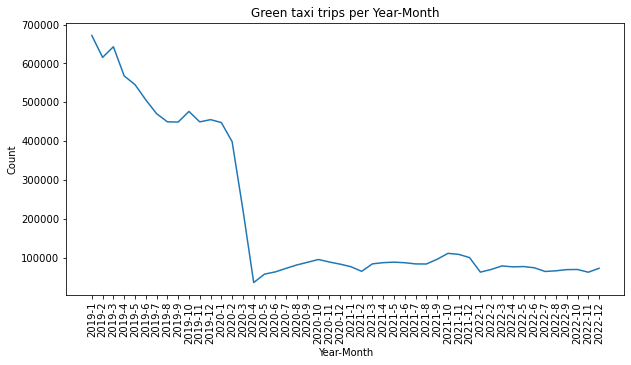

In [23]:
pd_df = count_df.toPandas()
plt.figure(figsize=(10, 5))
plt.plot(pd_df['year'].astype(str) + '-' + pd_df['month'].astype(str), pd_df['count'])
plt.title('Green taxi trips per Year-Month')
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.savefig('TAXI/plots/green_taxi_trips_per_month.png' , dpi=500)
plt.show()
plt.close()

# Reading Taxi Zone data

NOTE: Download Taxi_zones.shx, Taxi_zones.shp,Taxi_zones.prj,Taxi_zones.dbf files into your local repository from /shared/TAXI/ folder or obtain the shapefile data from https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc

In [24]:
#reading taxi zones shape files:
tzdata = gpd.read_file("Taxi_zones.shp")
tzdata.head()

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."


Text(0.5, 1.0, 'NYC Taxi Zones WGS84 (lat/lon)')

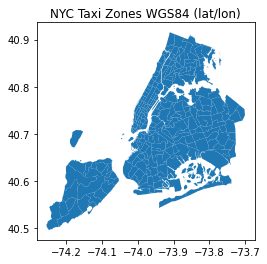

In [25]:
#Plotting all taxi zones
plotnyc = tzdata.plot()
plotnyc.set_title("NYC Taxi Zones WGS84 (lat/lon)")

# Plotting pickup frequency in different taxi zones

In [26]:
pu_count_df = cabs_df.groupBy('PULocationID').agg(count('*').alias('count')).orderBy('PULocationID')

pu_count_df.show(5)

+------------+-------+
|PULocationID|  count|
+------------+-------+
|        null|1704128|
|         0.0|  19835|
|         1.0|7122880|
|         2.0| 613597|
|         3.0| 118485|
+------------+-------+
only showing top 5 rows



In [27]:
PU_unique = pu_count_df.select('PULocationID').distinct().orderBy('PULocationID')
print(PU_unique.count())
PU_unique.show(5)

266


+------------+
|PULocationID|
+------------+
|        null|
|         0.0|
|         1.0|
|         2.0|
|         3.0|
+------------+
only showing top 5 rows



In [28]:
unique_loc_id = pd.unique(tzdata['location_i'])
print(len(unique_loc_id))
print(unique_loc_id)

260
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  24.  10.  11.  12.  13.
  18.  25.  14.  15.  22.  23.  16.  17.  19.  20.  21.  26.  27.  28.
  33.  29.  31.  32.  30.  34.  35.  36.  37.  38.  39.  40.  41.  45.
  46.  42.  43.  44.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  58.  59.  60.  61.  62.  63.  64.  65.  72.  66.  67.  68.  73.  69.
  70.  71.  79.  80.  74.  85.  86.  75.  76.  77.  78.  81.  87.  82.
  83.  84.  88.  89.  90. 125.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 106. 107. 108. 109. 110. 111. 112. 113. 114.
 115. 116. 117. 118. 119. 120. 149. 150. 121. 122. 123. 124. 126. 127.
 128. 129. 134. 151. 130. 139. 131. 132. 133. 140. 135. 136. 137. 141.
 142. 152. 138. 143. 144. 145. 146. 147. 148. 153. 154. 155. 156. 159.
 157. 158. 160. 161. 162. 163. 164. 170. 165. 166. 167. 178. 168. 169.
 171. 172. 173. 174. 175. 179. 176. 177. 180. 181. 182. 183. 184. 185.
 186. 189. 190. 187. 188. 191. 192. 193. 194. 196. 195. 203. 197. 198.
 1

In [29]:
pu_count_pd = pu_count_df.toPandas()
tzdata = tzdata.merge(pu_count_pd, left_on='location_i', right_on='PULocationID',how='left')
tzdata = tzdata.rename(columns={'count': 'pu_count'}).drop('PULocationID', axis=1)
tzdata['pu_count'] = tzdata['pu_count'].fillna(0)
tzdata.head()

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry,pu_count
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",7122880.0
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",613597.0
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",118485.0
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",307531.0
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",224611.0


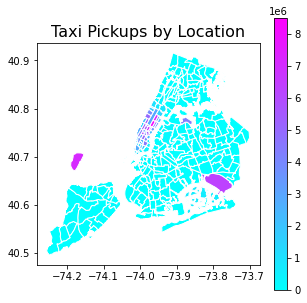

In [31]:
fig, ax = plt.subplots(figsize=(5, 5))
cmap = tzdata.plot(column='pu_count', cmap='cool', legend=True, ax=ax, edgecolor='white', vmin=0, vmax=8500000)
cmap.set_title("Taxi Pickups by Location", fontsize = 16)
fig.savefig("TAXI/plots/taxi_pickups.png")
plt.show()
plt.close()

# Plotting dropoff frequency in different taxi zones

In [32]:
do_count_df = cabs_df.groupBy('DOLocationID').agg(count('*').alias('count')).orderBy('DOLocationID')

In [33]:
do_count_pd = do_count_df.toPandas()
tzdata = tzdata.merge(do_count_pd, left_on='location_i', right_on='DOLocationID',how='left')
tzdata = tzdata.rename(columns={'count': 'do_count'}).drop('DOLocationID', axis=1)
tzdata['do_count'] = tzdata['do_count'].fillna(0)
tzdata.head()

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry,pu_count,do_count
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",7122880.0,454458.0
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",613597.0,43207.0
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",118485.0,43594.0
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",307531.0,782368.0
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",224611.0,12428.0


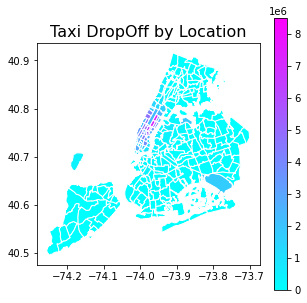

In [34]:
fig, ax = plt.subplots(figsize=(5, 5))
cmap = tzdata.plot(column='do_count', cmap='cool', legend=True, ax=ax, edgecolor='white', vmin=0, vmax=8500000)
cmap.set_title("Taxi DropOff by Location", fontsize = 16)
fig.savefig('TAXI/plots/taxi_dropoffs.png')
plt.show()
plt.close()

In [35]:
DO_unique = cabs_df.select('DOLocationID').distinct().orderBy(desc('DOLocationID'))
print(DO_unique.count())


11011


In [36]:
DO_unique.show(5)

+------------+
|DOLocationID|
+------------+
|   360068.14|
|   334303.19|
|   333574.57|
|   332302.69|
|   314199.07|
+------------+
only showing top 5 rows



# Plotting green cabs pickup frequency in different taxi zones

In [37]:
pu_count_df_green = cabs_df.where(cabs_df.taxi_type == 'green').groupBy('PULocationID').agg(count('*').alias('count')).orderBy('PULocationID')

pu_count_df_green.show(5)

+------------+-------+
|PULocationID|  count|
+------------+-------+
|        null|1704128|
|         0.0|  19835|
|         1.0|7098974|
|         2.0| 613423|
|         3.0| 111909|
+------------+-------+
only showing top 5 rows



In [38]:
pu_count_pd_green = pu_count_df_green.toPandas()
tzdata = tzdata.merge(pu_count_pd_green, left_on='location_i', right_on='PULocationID',how='left')
tzdata = tzdata.rename(columns={'count': 'pu_count_green'}).drop('PULocationID', axis=1)
tzdata['pu_count_green'] = tzdata['pu_count_green'].fillna(0)
tzdata.head()

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry,pu_count,do_count,pu_count_green
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",7122880.0,454458.0,7098974.0
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",613597.0,43207.0,613423.0
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",118485.0,43594.0,111909.0
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",307531.0,782368.0,40660.0
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",224611.0,12428.0,223396.0


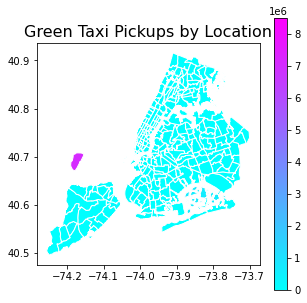

In [39]:
fig, ax = plt.subplots(figsize=(5, 5))
cmap = tzdata.plot(column='pu_count_green', cmap='cool', legend=True, ax=ax, edgecolor='white', vmin=0, vmax=8500000)
cmap.set_title("Green Taxi Pickups by Location", fontsize = 16)
fig.savefig('TAXI/plots/green_taxi_pickups.png')
plt.show()
plt.close()

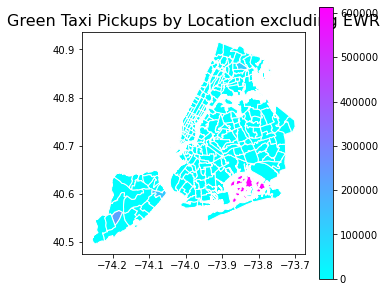

23/05/08 22:00:18 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 2 for reason Container marked as failed: container_e07_1683077339950_6424_01_000002 on host: nyu-dataproc-sw-xrlk.c.hpc-dataproc-19b8.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
23/05/08 22:00:18 ERROR org.apache.spark.scheduler.cluster.YarnScheduler: Lost executor 2 on nyu-dataproc-sw-xrlk.c.hpc-dataproc-19b8.internal: Container marked as failed: container_e07_1683077339950_6424_01_000002 on host: nyu-dataproc-sw-xrlk.c.hpc-dataproc-19b8.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
23/05/08 22:08:50 ERROR org.apache.spark.scheduler.cluster.YarnScheduler: Lost executor 1 on nyu-dataproc-sw-wmm2.c.hpc-dataproc-19b8.internal: Container marked as failed: container_e07_1683077339950_6424_01_000001 on host: nyu-dataproc-sw-wmm2.c.hpc-dataproc-19b8.internal. Exit status: -100. Diagnostic

In [62]:
fig, ax = plt.subplots(figsize=(5, 5))
cmap = tzdata.query('borough != "EWR"').plot(column='pu_count_green', cmap='cool', legend=True, ax=ax, edgecolor='white')
cmap.set_title("Green Taxi Pickups by Location excluding EWR", fontsize = 16)
fig.savefig('TAXI/plots/green_taxi_pickups_exclude_EWR.png')
plt.show()
plt.close()

# Plotting yellow cabs pickup frequency in different taxi zones

In [40]:
pu_count_df_yellow = cabs_df.where(cabs_df.taxi_type == 'yellow').groupBy('PULocationID').agg(count('*').alias('count')).orderBy('PULocationID')

pu_count_df_yellow.show(5)

+------------+------+
|PULocationID| count|
+------------+------+
|         1.0| 23906|
|         2.0|   174|
|         3.0|  6576|
|         4.0|266871|
|         5.0|  1215|
+------------+------+
only showing top 5 rows



In [41]:
pu_count_pd_yellow = pu_count_df_yellow.toPandas()
tzdata = tzdata.merge(pu_count_pd_yellow, left_on='location_i', right_on='PULocationID',how='left')
tzdata = tzdata.rename(columns={'count': 'pu_count_yellow'}).drop('PULocationID', axis=1)
tzdata['pu_count_yellow'] = tzdata['pu_count_yellow'].fillna(0)
tzdata.head()

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry,pu_count,do_count,pu_count_green,pu_count_yellow
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",7122880.0,454458.0,7098974.0,23906.0
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",613597.0,43207.0,613423.0,174.0
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",118485.0,43594.0,111909.0,6576.0
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",307531.0,782368.0,40660.0,266871.0
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",224611.0,12428.0,223396.0,1215.0


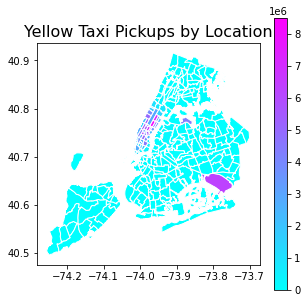

In [42]:
fig, ax = plt.subplots(figsize=(5, 5))
cmap = tzdata.plot(column='pu_count_yellow', cmap='cool', legend=True, ax=ax, edgecolor='white', vmin=0, vmax=8500000)
cmap.set_title("Yellow Taxi Pickups by Location", fontsize = 16)
fig.savefig('TAXI/plots/yellow_taxi_pickups.png')
plt.show()
plt.close()

# Plotting green cabs dropoff frequency in different taxi zones

In [43]:
do_count_df_green = cabs_df.where(cabs_df.taxi_type == 'green').groupBy('DOLocationID').agg(count('*').alias('count')).orderBy('DOLocationID')

do_count_df_green.show(5)

+------------+-----+
|DOLocationID|count|
+------------+-----+
|   -20329.08|    1|
|   -16183.31|    1|
|   -13844.68|    1|
|    -9436.33|    1|
|    -4311.35|    1|
+------------+-----+
only showing top 5 rows



In [44]:
from pyspark.sql.functions import col

filtered_df = do_count_df_green.filter((col('DOLocationID') >= 0) & (col('DOLocationID') <= 260))
filtered_df.show(300)

+------------+------+
|DOLocationID| count|
+------------+------+
|         0.0|292927|
|        0.01| 13584|
|        0.02| 10057|
|        0.03|  8019|
|        0.04|  6315|
|        0.05|  5469|
|        0.06|  4910|
|        0.07|  4449|
|        0.08|  4133|
|        0.09|  3757|
|         0.1|  9400|
|        0.11|  3336|
|        0.12|  3226|
|        0.13|  3235|
|        0.14|  3123|
|        0.15|  3055|
|        0.16|  3014|
|        0.17|  2979|
|        0.18|  3078|
|        0.19|  3064|
|         0.2|  8475|
|        0.21|  3248|
|        0.22|  3331|
|        0.23|  3477|
|        0.24|  3830|
|        0.25|  4242|
|        0.26|  4366|
|        0.27|  4685|
|        0.28|  4904|
|        0.29|  5238|
|         0.3| 15447|
|        0.31|  5849|
|        0.32|  6181|
|        0.33|  6955|
|        0.34|  7290|
|        0.35|  7780|
|        0.36|  8154|
|        0.37|  8656|
|        0.38|  9155|
|        0.39|  9486|
|         0.4| 28126|
|        0.41| 10697|
|        0

In [45]:
do_count_pd_green = do_count_df_green.toPandas()
tzdata = tzdata.merge(do_count_pd_green, left_on='location_i', right_on='DOLocationID',how='left')
tzdata = tzdata.rename(columns={'count': 'do_count_green'}).drop('DOLocationID', axis=1)
tzdata['do_count_green'] = tzdata['do_count_green'].fillna(0)
tzdata.head()

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry,pu_count,do_count,pu_count_green,pu_count_yellow,do_count_green
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",7122880.0,454458.0,7098974.0,23906.0,73914.0
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",613597.0,43207.0,613423.0,174.0,42965.0
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",118485.0,43594.0,111909.0,6576.0,25019.0
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",307531.0,782368.0,40660.0,266871.0,15363.0
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",224611.0,12428.0,223396.0,1215.0,10243.0


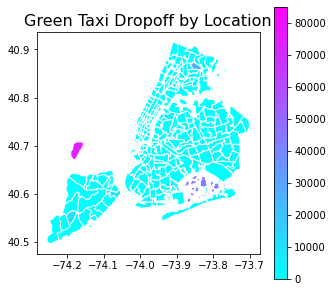

In [46]:
fig, ax = plt.subplots(figsize=(5, 5))
cmap = tzdata.plot(column='do_count_green', cmap='cool', legend=True, ax=ax, edgecolor='white', vmin=0, vmax=85000)
cmap.set_title("Green Taxi Dropoff by Location", fontsize = 16)
fig.savefig('TAXI/plots/Green_taxi_dropoffs.png')
plt.show()
plt.close()

# Plotting yellow cabs dropoff frequency in different taxi zones

In [47]:
do_count_df_yellow = cabs_df.where(cabs_df.taxi_type == 'yellow').groupBy('DOLocationID').agg(count('*').alias('count')).orderBy('DOLocationID')

do_count_df_yellow.show(5)

+------------+------+
|DOLocationID| count|
+------------+------+
|         1.0|380544|
|         2.0|   242|
|         3.0| 18575|
|         4.0|767005|
|         5.0|  2185|
+------------+------+
only showing top 5 rows



In [48]:
do_count_pd_yellow = do_count_df_yellow.toPandas()
tzdata = tzdata.merge(do_count_pd_yellow, left_on='location_i', right_on='DOLocationID',how='left')
tzdata = tzdata.rename(columns={'count': 'do_count_yellow'}).drop('DOLocationID', axis=1)
tzdata['do_count_yellow'] = tzdata['do_count_yellow'].fillna(0)
tzdata.head()

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry,pu_count,do_count,pu_count_green,pu_count_yellow,do_count_green,do_count_yellow
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",7122880.0,454458.0,7098974.0,23906.0,73914.0,380544.0
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",613597.0,43207.0,613423.0,174.0,42965.0,242.0
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",118485.0,43594.0,111909.0,6576.0,25019.0,18575.0
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",307531.0,782368.0,40660.0,266871.0,15363.0,767005.0
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",224611.0,12428.0,223396.0,1215.0,10243.0,2185.0


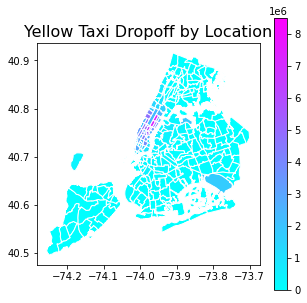

In [49]:
fig, ax = plt.subplots(figsize=(5, 5))
cmap = tzdata.plot(column='do_count_yellow', cmap='cool', legend=True, ax=ax, edgecolor='white', vmin=0, vmax=8500000)
cmap.set_title("Yellow Taxi Dropoff by Location", fontsize = 16)
fig.savefig('TAXI/plots/yellow_taxi_dropoffs.png')
plt.show()
plt.close()

# Plotting pickup frequency in different taxi zones in 2019,2020,2021 and 2022 by the year

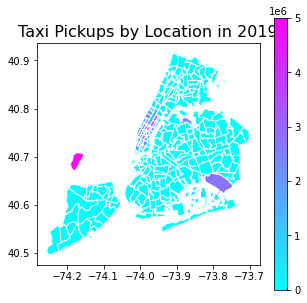

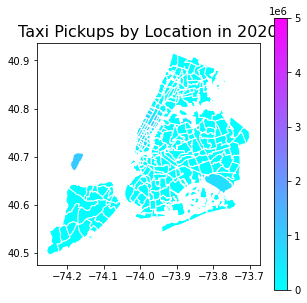

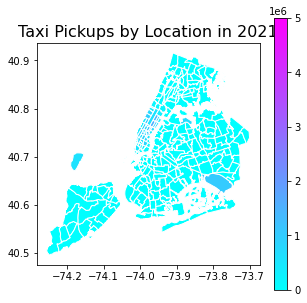

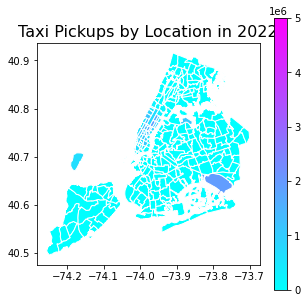

In [50]:
for i in range(19,23):
    pu_count_df_year = cabs_df.where(cabs_df.year == 2000+i).groupBy('PULocationID').agg(count('*').alias('count')).orderBy('PULocationID')
    pu_count_pd_year = pu_count_df_year.toPandas()
    tzdata = tzdata.merge(pu_count_pd_year, left_on='location_i', right_on='PULocationID',how='left')
    tzdata = tzdata.rename(columns={'count': 'pu_count_20'+str(i)}).drop('PULocationID', axis=1)
    tzdata['pu_count_20'+str(i)] = tzdata['pu_count_20'+str(i)].fillna(0)
    tzdata.head()
    fig, ax = plt.subplots(figsize=(5, 5))
    cmap = tzdata.plot(column='pu_count_20'+str(i), cmap='cool', legend=True, ax=ax, edgecolor='white', vmin=0, vmax=5000000)
    cmap.set_title("Taxi Pickups by Location in 20"+str(i), fontsize = 16)
    fig.savefig("TAXI/plots/taxi_pickups_20"+str(i)+".png")
    plt.show()
    plt.close()


# Plotting dropoff frequency in different taxi zones in 2019,2020,2021 and 2022 by the year

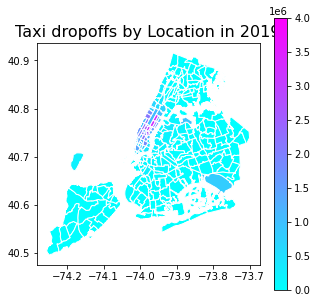

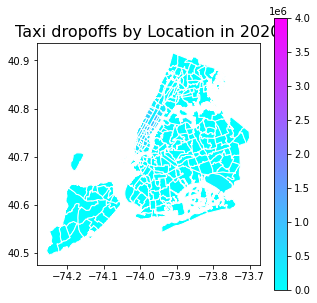

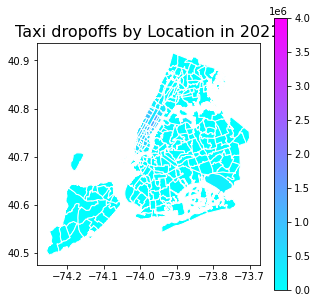

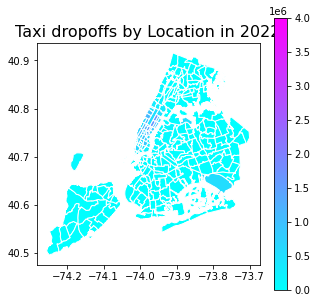

In [51]:
for i in range(19,23):
    do_count_df_year = cabs_df.where(cabs_df.year == 2000+i).groupBy('DOLocationID').agg(count('*').alias('count')).orderBy('DOLocationID')
    do_count_pd_year = do_count_df_year.toPandas()
    tzdata = tzdata.merge(do_count_pd_year, left_on='location_i', right_on='DOLocationID',how='left')
    tzdata = tzdata.rename(columns={'count': 'do_count_20'+str(i)}).drop('DOLocationID', axis=1)
    tzdata['do_count_20'+str(i)] = tzdata['do_count_20'+str(i)].fillna(0)
    tzdata.head()
    fig, ax = plt.subplots(figsize=(5, 5))
    cmap = tzdata.plot(column='do_count_20'+str(i), cmap='cool', legend=True, ax=ax, edgecolor='white', vmin=0, vmax=4000000)
    cmap.set_title("Taxi dropoffs by Location in 20"+str(i), fontsize = 16)
    fig.savefig("TAXI/plots/taxi_dropoffs_20"+str(i)+".png")
    plt.show()
    plt.close()


# Plotting daily fare

In [52]:
cabs_df.show(5)

+--------+---------------+-------------+----------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------+-------------------+-------------------+-----+----+-----------+
|VendorID|passenger_count|trip_distance|RatecodeID|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|taxi_type|   pickup_date_time|  dropoff_date_time|month|year|pickup_date|
+--------+---------------+-------------+----------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------+-------------------+-------------------+-----+----+-----------+
|       1|            1.0|          0.0|       1.0|       145.0|       145.0|         2.0|        2.5|  0.5|    0.5|       0.0|         0.0|              

In [53]:
total_amount_per_day_df = cabs_df.groupBy(['taxi_type', 'pickup_date']).agg(sum('total_amount').alias('total_amount_per_day')).orderBy(['pickup_date'])

total_amount_per_day_df.show()

+---------+-----------+--------------------+
|taxi_type|pickup_date|total_amount_per_day|
+---------+-----------+--------------------+
|   yellow| 2019-01-01|  3211108.3199964906|
|    green| 2019-01-01|   269440.3399999525|
|   yellow| 2019-01-02|  3351984.7599960226|
|    green| 2019-01-02|  364589.70999992784|
|    green| 2019-01-03|  401273.69999990956|
|   yellow| 2019-01-03|   3578111.719994862|
|   yellow| 2019-01-04|   3699512.519994122|
|    green| 2019-01-04|   416698.3899999031|
|    green| 2019-01-05|  337079.38999992784|
|   yellow| 2019-01-05|  3381144.5099953953|
|    green| 2019-01-06|  319708.12999993947|
|   yellow| 2019-01-06|  3244994.0399966612|
|    green| 2019-01-07|   390214.6799999148|
|   yellow| 2019-01-07|   3643272.789994837|
|    green| 2019-01-08|  396954.34999991785|
|   yellow| 2019-01-08|   3736089.329994548|
|   yellow| 2019-01-09|   4022395.399993465|
|    green| 2019-01-09|   430729.6699999069|
|    green| 2019-01-10|   453771.1799998931|
|   yellow

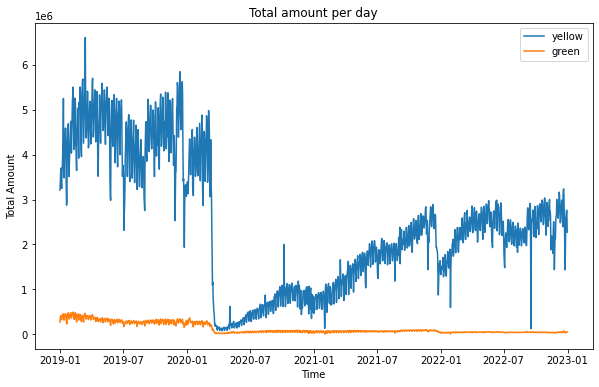

In [54]:
total_amount_per_day_pd = total_amount_per_day_df.toPandas()
fig, ax = plt.subplots(figsize=(10, 6))
for taxi_type in ['yellow', 'green']:
    data = total_amount_per_day_pd[total_amount_per_day_pd['taxi_type'] == taxi_type]
    ax.plot(data['pickup_date'], data['total_amount_per_day'], label=taxi_type)
ax.set_title('Total amount per day')
ax.set_xlabel('Time')
ax.set_ylabel('Total Amount')
ax.legend()
fig.savefig("TAXI/plots/total_fare_amount_per_day.png")
plt.show()
plt.close()

# Plotting average fare per unit distance

In [55]:
avg_amount_per_mile_df = cabs_df.groupBy(['taxi_type', 'pickup_date']).agg(sum('total_amount').alias('total_amount_per_day'), 
                                    sum('trip_distance').alias('total_distance')).orderBy(['pickup_date'])

avg_amount_per_mile_df.show()

+---------+-----------+--------------------+-----------------+
|taxi_type|pickup_date|total_amount_per_day|   total_distance|
+---------+-----------+--------------------+-----------------+
|    green| 2019-01-01|   269440.3399999525|          18729.0|
|   yellow| 2019-01-01|  3211108.3199964906|671065.9599999897|
|   yellow| 2019-01-02|  3351984.7599960226|643724.5000000003|
|    green| 2019-01-02|  364589.70999992784|          25272.0|
|    green| 2019-01-03|  401273.69999990956|          27623.0|
|   yellow| 2019-01-03|   3578111.719994862| 670797.390000005|
|   yellow| 2019-01-04|   3699512.519994122|671178.5800000156|
|    green| 2019-01-04|   416698.3899999031|          29003.0|
|   yellow| 2019-01-05|  3381144.5099953953|633754.0900000015|
|    green| 2019-01-05|  337079.38999992784|          24713.0|
|    green| 2019-01-06|  319708.12999993947|          22705.0|
|   yellow| 2019-01-06|  3244994.0399966612|646225.3899999866|
|    green| 2019-01-07|   390214.6799999148|          2

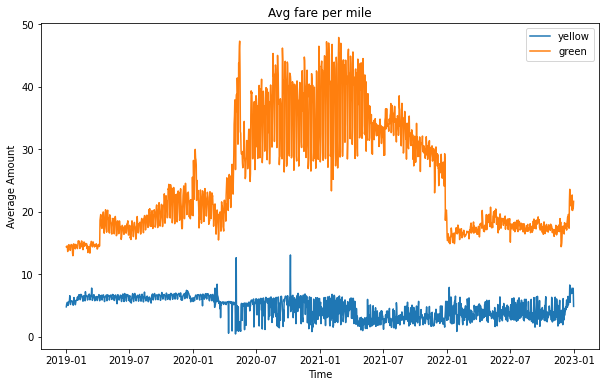

In [56]:
avg_amount_per_mile_pd = avg_amount_per_mile_df.toPandas()
fig, ax = plt.subplots(figsize=(10, 6))
for taxi_type in ['yellow', 'green']:
    data = avg_amount_per_mile_pd[avg_amount_per_mile_pd['taxi_type'] == taxi_type]
    ax.plot(data['pickup_date'], data['total_amount_per_day']/data['total_distance'], label=taxi_type)
ax.set_title('Avg fare per mile')
ax.set_xlabel('Time')
ax.set_ylabel('Average Amount')
ax.legend()
fig.savefig("TAXI/plots/average_fare_amount_per_mile.png")
plt.show()
plt.close()